## Loading the Inception model from the [Applications of Keras](https://keras.io/applications/) or [Transfer learning with a pretrained ConvNet](https://www.tensorflow.org/tutorials/images/transfer_learning)
Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

Weights are downloaded automatically when instantiating a model.

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from google.colab import drive
drive.mount('/content/drive')

import os
path = "/content/drive/MyDrive/semester 2/AM216/HW4" # Your path here
os.chdir(path)


Mounted at /content/drive


## (b)  [Rayleigh-Bénard Convection](https://en.wikipedia.org/wiki/Rayleigh%E2%80%93B%C3%A9nard_convection)

RB convection, in which a flow is heated from below and cooled  from  top,  is  one  of  the  paradigmatic  system  in  fluid  dynamics. When the temperature difference between the two plates (in dimensionless form Rayleigh number Ra) is beyond certain threshold, hot fluid tends to go up and cold fluid tends to go down, thus forming convection cells. What we supply here are the temperature snapshots from four different Ra, i.e., $Ra=10^{14}$ as `class0`,$Ra= 10^{13}$ as `class1`, $Ra= 10^{12}$ as `class2`,and $Ra= 10^{11}$ as `class3`.  The flow you see is highly turbulent; not only there are big convection cells but also lots of small vortices.  The original dataset  is  around  4000*2000.   We  have  already  downsampled  the  data into the zip file `fluid_org.zip`.

### (3) Explore the potential of transfer learning on cropped data `fluid-crop`, which are randomly choosen regions of 100x100 pixels from each original 4000x2000 pictures, i.e.,just around 1% of the original picture! 
You can use either method you use in (1) or (2).

Solution to (3):

Need to change the size of the images from fluid - org to 100 by 100 import os
from PIL import Image
imgs = []
labels = []
for file in os.listdir('./fluid_org/'):
    imgs.append(np.array(Image.open('./fluid_org/'+file))/255)
    labels.append(int(file[-5]))

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt


In [ ]:
import os
from PIL import Image
imgs = []
labels = []
for file in os.listdir('./fluid_org/'):
    imgs.append(np.array(Image.open('./fluid_org/'+file))/255)
    labels.append(int(file[-5]))


imgs_crop = []
labels_crop = []
for file in os.listdir('./fluid_crop/'):
    imgs_crop.append(np.array(Image.open('./fluid_crop/'+file))/255)
    labels_crop.append(int(file[-5]))
    
    
imgs = np.array(imgs)
labels = np.array(labels)
imgs_crop = np.array(imgs_crop[:100])
labels_crop = np.array(labels_crop[:100])


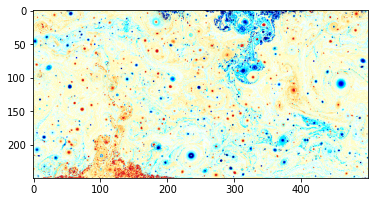

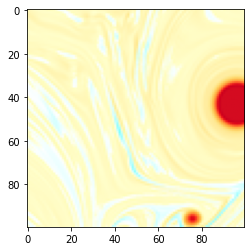

In [ ]:
import matplotlib.pyplot as plt

test = imgs[0]
test.shape

test1 = np.resize(test,(100,100,3))
test1.shape

plt.figure()
plt.imshow(test)
plt.figure()
plt.imshow(imgs_crop[0])

In [ ]:
crop_shape = imgs_crop.shape[1:]

In [ ]:
# Showing that padding works
crop_shape
pad = np.zeros((250,500,3))
pad[:crop_shape[0],:crop_shape[1],:] = imgs_crop[0]
pad.shape


(250, 500, 3)

In [ ]:
padded_crop = []
crop_shape = imgs_crop.shape[1:]
for i in range(len(imgs_crop)):
    pad = np.zeros((250,500,3))
    pad[:crop_shape[0],:crop_shape[1],:] = imgs_crop[i]
    padded_crop.append(pad)
    
padded_crop = np.array(padded_crop)   

In [ ]:
# Steps: Load Model
# need to train on original data first 
base_model = tf.keras.applications.InceptionV3(input_shape =(250,500,3),include_top = False, weights = "imagenet", classes = 4)
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 250, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 124, 249, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 124, 249, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In [ ]:
# inputs = keras.Input(shape=(250,500,3))
# global_avg_layer = keras.layers.GlobalAveragePooling2D()

# classifier_layer = tf.keras.layers.Dense(4)
# layers = [inputs, base_model,global_avg_layer,classifier_layer]
# transfer_model = tf.keras.Sequential(layers)
base_model.trainable = False

inputs = keras.Input(shape=(250,500,3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(4)(x)  # because there are four outputs
transfer_model = keras.Model(inputs, outputs)

transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 14, 2048)       21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 21,776,548
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# now train on original uncropped images
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),     
              loss=loss_fn,         
              metrics=['accuracy']) 

transfer_model.fit(imgs, labels, epochs=5)

Epoch 1/10
24/24 [==============================] - 45s 1s/step - loss: 1.2725 - accuracy: 0.7510
Epoch 2/10
24/24 [==============================] - 30s 1s/step - loss: 0.8480 - accuracy: 0.8642
Epoch 3/10
24/24 [==============================] - 30s 1s/step - loss: 0.4378 - accuracy: 0.9001
Epoch 4/10
24/24 [==============================] - 30s 1s/step - loss: 0.5408 - accuracy: 0.9774
Epoch 5/10
24/24 [==============================] - 30s 1s/step - loss: 0.4857 - accuracy: 0.9814
Epoch 6/10
24/24 [==============================] - 30s 1s/step - loss: 0.6692 - accuracy: 0.9734
Epoch 7/10
24/24 [==============================] - 30s 1s/step - loss: 0.5722 - accuracy: 0.9814
Epoch 8/10
24/24 [==============================] - 30s 1s/step - loss: 0.5390 - accuracy: 0.9840
Epoch 9/10
24/24 [==============================] - 30s 1s/step - loss: 0.5335 - accuracy: 0.9800
Epoch 10/10
24/24 [==============================] - 30s 1s/step - loss: 0.5206 - accuracy: 0.9920


In [ ]:
# make test/train split
crop_train, crop_test, clabels_train, clabels_test = train_test_split(padded_crop, labels_crop, test_size = 0.2)


In [ ]:
base_model.trainable = False

inputs = keras.Input(shape=(250,500,3))
global_avg_layer = keras.layers.GlobalAveragePooling2D()

classifier_layer = tf.keras.layers.Dense(4)
layers = [inputs, base_model,global_avg_layer,classifier_layer]
transfer_model = tf.keras.Sequential(layers)

transfer_model.summary()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
transfer_model.compile(optimizer='adam',     
              loss=loss_fn,         
              metrics=['accuracy']) 

transfer_model.fit(crop_train, clabels_train, epochs=10)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 14, 2048)       21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 18s 2s/step - loss: 6.4742 - accuracy: 0.0625
Epoch 2/10
3/3 [==============================] - 1s 301ms/step - loss: 0.0859 - accuracy: 1.0000
Epoch 3/10
3/3 [==========================

In [ ]:
transfer_model.evaluate(crop_test,clabels_test)

1/1 [==============================] - 2s 2s/step - loss: 3.5763e-07 - accuracy: 1.0000


[3.576278118089249e-07, 1.0]